# Load TraCE data
Ref He et al., 2011

In [1]:
import xarray as xr

path='D:/VScode/Last_deglaciation/TraCE_data/'

trace_allforcing_sat = xr.open_dataset(path+'trace.01-36.22000BP.cam2.TREFHT.22000BP_decavg_400BCE.nc')
trace_allforcing_sic=xr.open_dataset(path+'trace.01-36.22000BP.cam2.ICEFRAC.22000BP_decavg_400BCE.nc')


trace_allforcing_sat = trace_allforcing_sat.rename({'TREFHT': 'sat'})
trace_allforcing_sat = trace_allforcing_sat.rename({'time': 'age'})
trace_allforcing_sat['age'] = trace_allforcing_sat['age'] * -1000
trace_allforcing_sat['sat'] = trace_allforcing_sat['sat'] - 273.15
trace_allforcing_sat = trace_allforcing_sat[['sat']]


trace_allforcing_sic = trace_allforcing_sic.rename({'time': 'age'})
trace_allforcing_sic['age'] = trace_allforcing_sic['age'] * -1000
trace_allforcing_sic = trace_allforcing_sic[['ICEFRAC']]


trace_orb = xr.open_dataset(path + 'b30.00_4kaDVTj.cam2.ncrcat.ann.nc')
trace_orb = trace_orb.rename({'TREFHT': 'sat'})
trace_orb = trace_orb.rename({'time': 'age'})
trace_orb['age'] = trace_orb['age'] * -1000
trace_orb['sat'] = trace_orb['sat'] - 273.15 # convert to Celsius

trace_orb_sat = trace_orb[['sat']]
trace_orb_sic = trace_orb[['ICEFRAC']]


# Calculate the sea ice area

In [2]:
import xarray as xr
import numpy as np
import pickle

def calculate_seaice_area(ds_seaice, variable_name='sic',lat_min=-90,lat_max=0):    
    # Subset dataset for latitude from -90 to 0
    ds_seaice_subset = ds_seaice.sel(lat=slice(lat_min, lat_max))

    # Constants
    R = 6371  # Earth's radius in km
    delta_theta = 2.5 / 180 * np.pi  # 2.5 degree in radians

    # Convert latitude values to radians and compute latitudinal boundaries
    lat_radians = np.radians(ds_seaice_subset['lat'].values)
    lat_boundaries = (lat_radians[:-1] + lat_radians[1:]) / 2

    # area of each grid, 
    # Ref: https://www.johndcook.com/blog/2023/02/21/sphere-grid-area/#:~:text=Area%20of%20latitude%2Flongitude%20grid&text=A%20%3D%20%CF%80%20R%C2%B2%20(sin%20%CF%86,1%20%E2%88%92%20%CE%B82)%2F180.
    A = R**2 * delta_theta * (np.sin(lat_boundaries[1:]) - np.sin(lat_boundaries[:-1]))
    A_center_lats = ds_seaice_subset['lat'].values[1:-1]

    # Reduce dataset size
    ds_seaice_subset_reduced = ds_seaice_subset.isel(lat=slice(1, -1))

    # Create an xarray DataArray for A
    A_xr = xr.DataArray(A, dims=["lat"], coords={"lat": A_center_lats})

    # Multiply sic data with A
    sic = ds_seaice_subset_reduced[variable_name]
    sic_area = sic * A_xr

    # Sum up the resulting product
    LGMR_sic_area = sic_area.sum(dim=["lat", "lon"]).values / 1e6
    # print('LGMR_sic_area:', LGMR_sic_area.shape)

    # Add age to LGMR_sic_area
    LGMR_sic_area = np.column_stack((ds_seaice_subset_reduced['age'].values, LGMR_sic_area))

    return LGMR_sic_area


In [3]:
asice_trace_allforcing_sh=calculate_seaice_area(trace_allforcing_sic, variable_name='ICEFRAC',lat_min=-90,lat_max=0) 
asice_trace_allforcing_nh=calculate_seaice_area(trace_allforcing_sic, variable_name='ICEFRAC',lat_min=0,lat_max=90)

asice_trace_orb_sh=calculate_seaice_area(trace_orb_sic, variable_name='ICEFRAC',lat_min=-90,lat_max=0)
asice_trace_orb_nh=calculate_seaice_area(trace_orb_sic, variable_name='ICEFRAC',lat_min=0,lat_max=90)

In [6]:
# save the data to '/TraCE_data/'
path='TraCE_data/'
with open(path+'asice_trace_allforcing_sh.pkl', 'wb') as f:
    pickle.dump(asice_trace_allforcing_sh, f)
with open(path+'asice_trace_allforcing_nh.pkl', 'wb') as f:
    pickle.dump(asice_trace_allforcing_nh, f)

with open(path+'asice_trace_orb_sh.pkl', 'wb') as f:
    pickle.dump(asice_trace_orb_sh, f)

with open(path+'asice_trace_orb_nh.pkl', 'wb') as f:
    pickle.dump(asice_trace_orb_nh, f)

In [1]:
# read the data
import pickle
path='TraCE_data/'
with open(path+'asice_trace_allforcing_sh.pkl', 'rb') as f:
    asice_trace_allforcing_sh = pickle.load(f)
with open(path+'asice_trace_allforcing_nh.pkl', 'rb') as f:
    asice_trace_allforcing_nh = pickle.load(f)

with open(path+'asice_trace_orb_sh.pkl', 'rb') as f:
    asice_trace_orb_sh = pickle.load(f)
with open(path+'asice_trace_orb_nh.pkl', 'rb') as f:
    asice_trace_orb_nh = pickle.load(f)

# Load EBM and proxy data

In [2]:
import pandas as pd
import numpy as np


file_path = 'D:/VScode/EBM_NH_SH_sea_ice/EBM_data/'


# Replace these paths with the actual paths to your CSV files
nh_csv_file_path = file_path+'results_nh_n400_age0to200ka_20240208_0853.csv'
sh_csv_file_path = file_path+'results_sh_n400_age0to200ka_20240208_0853.csv'

# Read the CSV files
results_nh_df = pd.read_csv(nh_csv_file_path)
results_sh_df = pd.read_csv(sh_csv_file_path)

# rename columns to 'age' 'T' and 'iceA'
results_nh_df.columns = ['age', 'T', 'iceA']
results_sh_df.columns = ['age', 'T', 'iceA']

delta_age=9
# correct the age
results_nh_df['age'] = results_nh_df['age'] - delta_age
results_sh_df['age'] = results_sh_df['age'] - delta_age

# # the iceA should substract to 14 to minors the 
# results_nh_df['iceA'] = results_nh_df['iceA'] - 14
# results_sh_df['iceA'] = results_sh_df['iceA'] - 14

# read D:\VScode\EBM_NH_SH_sea_ice\proxy_data\Sadatzki_2023_data.xlsx
df_proxy_EASIC = pd.read_excel('proxy_data/Sadatzki_2023_data.xlsx')
# rename the columns to 'age' and 'pipso25c0.45' and 'pipso25c1'
df_proxy_EASIC.columns = ['age', 'pipso25c0.45', 'pipso25c1']
df_proxy_EASIC


df_proxy_seaice_pc = pd.read_csv('proxy_data/Chadwick et al-2022_Stacks_PCA_pc.csv')
# get the first and second column
df_proxy_seaice_pc = df_proxy_seaice_pc.iloc[:, [0, 1]]
# rename the column
df_proxy_seaice_pc.columns = ['age', 'pc1']
# resample the data from 0 to 200 with 1 kyr interval
target_ages = np.arange(0, 150, 1)
interpolated_pc1 = np.interp(target_ages, df_proxy_seaice_pc.age.values, df_proxy_seaice_pc.pc1.values)
df_proxy_seaice_pc = pd.DataFrame({'age': target_ages, 'pc1': interpolated_pc1})
df_proxy_seaice_pc

# read the D:\VScode\EBM_NH_SH_sea_ice\proxy_data\41467_2019_9237_MOESM6_ESM.xlsx
df_NA_14C= pd.read_excel('proxy_data/41467_2019_9237_MOESM6_ESM.xlsx', sheet_name='B-P age',skiprows=2)
# get the first two columns
df_NA_14C = df_NA_14C.iloc[:, [0, 1]]
# rename colums to 'age' and 'd14C'
df_NA_14C.columns = ['age', 'B-P age']
df_NA_14C

,age,B-P age
0,10640,277.6
1,10650,272.2
2,10660,273.6
3,10670,281.1
4,10680,276.4
...,...,...
465,15290,1405.0
466,15300,1401.6
467,15310,1406.6
468,15320,1412.8


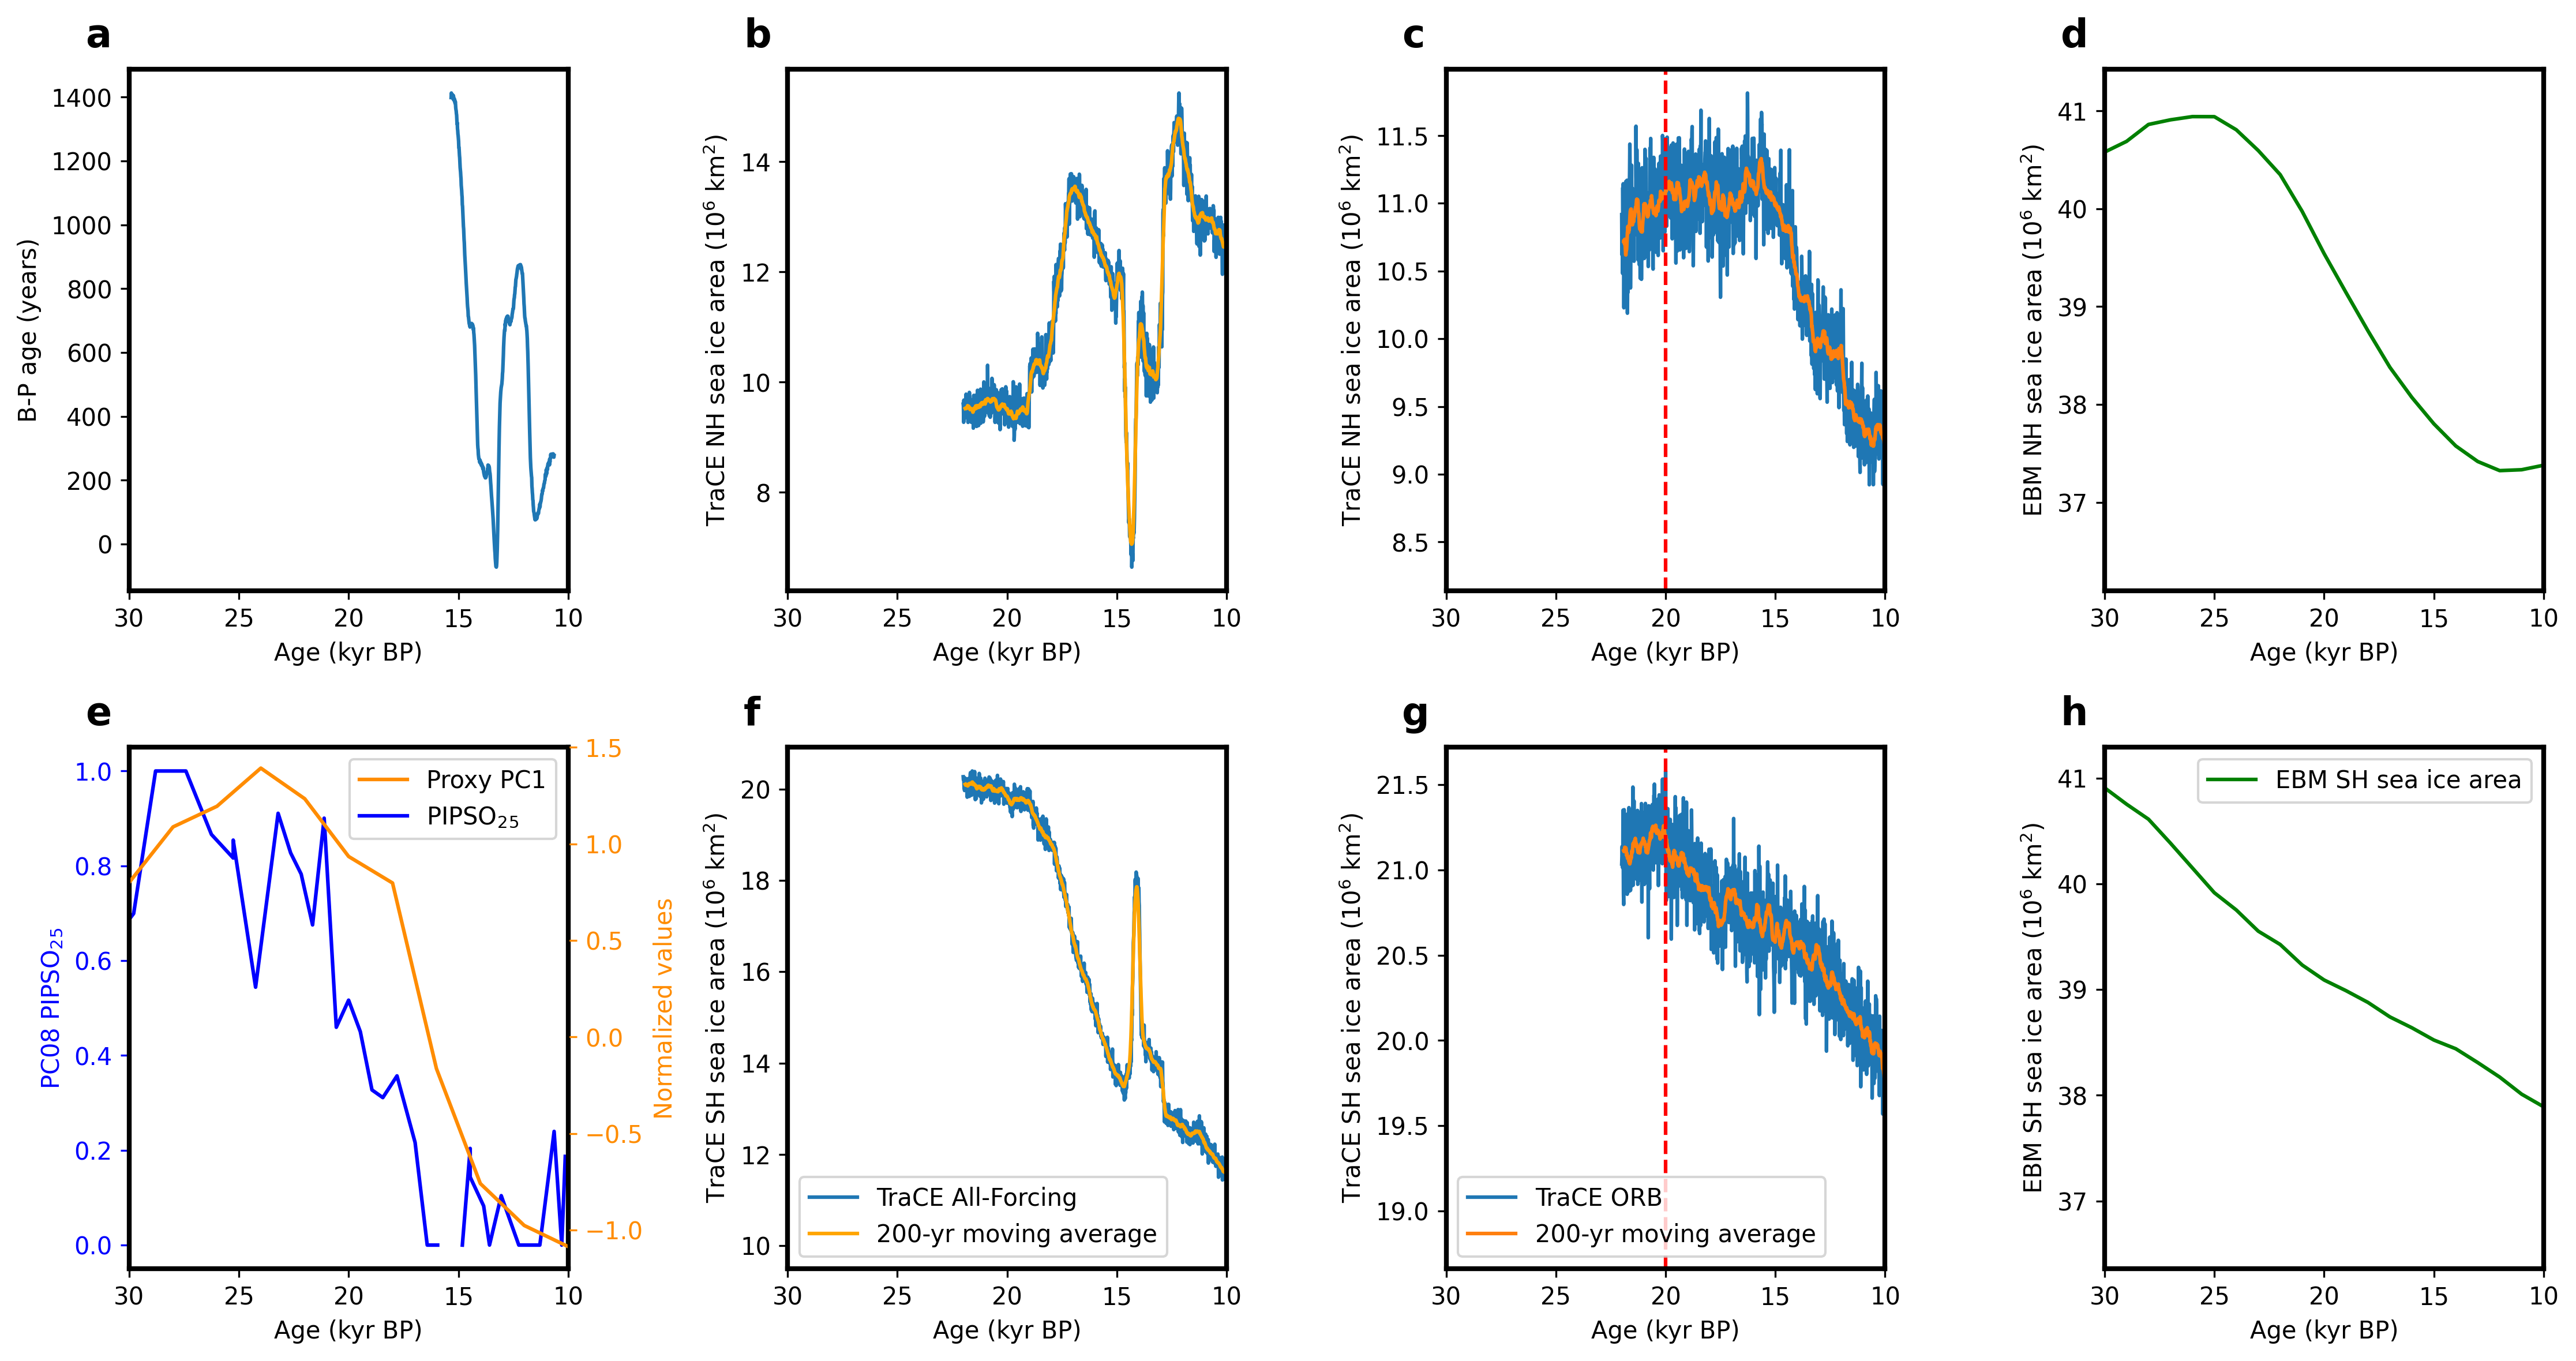

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Define a moving average function
def moving_average(data, points=10):
    return np.convolve(data, np.ones(points)/points, mode='valid')

# Create a 4 by 2 subplot layout to accommodate the two new rows of empty subplots
fig, axs = plt.subplots(2, 4, figsize=(18, 9), dpi=300) # Adjusted figsize to accommodate the new layout
# fig.suptitle('Sea ice area comparison')

smoothing_len = 20

# Assuming asice_trace_orb_sh, asice_trace_orb_nh, results_sh_df, and results_nh_df are defined elsewhere in your code

# Apply the moving average
smoothed_asice_trace_orb_sh = moving_average(asice_trace_orb_sh[:, 1], smoothing_len)
smoothed_asice_trace_orb_nh = moving_average(asice_trace_orb_nh[:, 1], smoothing_len)
smoothed_asice_trace_allforcing_sh = moving_average(asice_trace_allforcing_sh[:, 1], smoothing_len)
smoothed_asice_trace_allforcing_nh = moving_average(asice_trace_allforcing_nh[:, 1], smoothing_len)

# Adjust x-axis data for moving average
adjusted_x_sh = asice_trace_orb_sh[9:-10, 0]
adjusted_x_nh = asice_trace_orb_nh[9:-10, 0]

# plot df_NA_14C
axs[0, 0].plot(df_NA_14C['age'].values/1000, df_NA_14C['B-P age'], label='proxy')
# axs[0, 0].set_title('NA')
axs[0, 0].set_xlabel('Age (kyr BP)')
axs[0, 0].set_ylabel('B-P age (years)')


# plot the df_proxy_seaice_pc on the second subplot
# axs[0, 0].plot(df_proxy_seaice_pc['age'], df_proxy_seaice_pc['pc1'], label='proxy')
# plot the first two columns of the proxy data
axs[1, 0].plot(df_proxy_EASIC['age'], df_proxy_EASIC['pipso25c0.45'], color='b',label='proxy')
# axs[1, 0].set_title('SH')
axs[1, 0].set_xlabel('Age (kyr BP)')
axs[1, 0].set_ylabel('PC08 PIPSO$_2$$_5$')
axs[1, 0].invert_xaxis()
# set the color of ylabels and ytick labels to match the line color
axs[1, 0].yaxis.label.set_color('blue')
axs[1, 0].tick_params(axis='y', colors='blue')

ax2 = axs[1, 0].twinx()
ax2.plot(df_proxy_seaice_pc['age'], df_proxy_seaice_pc['pc1'], label='Proxy PC1', color='darkorange')
ax2.plot(0,-2, color='b',label='PIPSO$_2$$_5$')
# set ylim
ax2.set_ylim([-1.2,1.5])
ax2.set_ylabel('Normalized values')
ax2.invert_xaxis()
ax2.yaxis.label.set_color('darkorange')
ax2.tick_params(axis='y', colors='darkorange')
ax2.legend()





# axs[1,0].plot(asice_trace_orb_sh[:, 0], asice_trace_orb_sh[:, 1], label='raw data')
# axs[1,0].plot(adjusted_x_sh, smoothed_asice_trace_orb_sh,label='200-yr moving average')
axs[1,1].plot(asice_trace_allforcing_sh[:, 0]/1000, asice_trace_allforcing_sh[:, 1], label='TraCE All-Forcing')
axs[1,1].plot(adjusted_x_sh/1000, smoothed_asice_trace_allforcing_sh,label='200-yr moving average',color='orange')
# axs[1,0].set_title('SH')
axs[1,1].set_xlabel('Age (kyr BP)')
axs[1,1].set_ylabel('TraCE SH sea ice area ($10^6$ km$^2$)')
axs[1,1].legend()
axs[1,1].invert_xaxis()



# axs[1,1].plot(asice_trace_orb_nh[:, 0], asice_trace_orb_nh[:, 1], label='NH')
# axs[1,1].plot(adjusted_x_nh, smoothed_asice_trace_orb_nh)
axs[0,1].plot(asice_trace_allforcing_nh[:, 0]/1000, asice_trace_allforcing_nh[:, 1], label='allforcing')
axs[0,1].plot(adjusted_x_nh/1000, smoothed_asice_trace_allforcing_nh,label='allforcing 200-yr moving average',color='orange')
# axs[1,1].set_title('NH')
axs[0,1].set_xlabel('Age (kyr BP)')
axs[0,1].set_ylabel('TraCE NH sea ice area ($10^6$ km$^2$)')
axs[0,1].invert_xaxis()

# You must update the indexes for the existing plots from axs[0, X] and axs[1, X] to axs[2, X] and axs[3, X]
# Plotting TraCE data
axs[1, 2].plot(asice_trace_orb_sh[:, 0]/1000, asice_trace_orb_sh[:, 1], label='TraCE ORB')
axs[1, 2].plot(adjusted_x_sh/1000, smoothed_asice_trace_orb_sh, label='200-yr moving average')
# axs[2, 0].set_title('TraCE orbital forcing, SH')
axs[1, 2].set_xlabel('Age (kyr BP)')
axs[1, 2].set_ylabel('TraCE SH sea ice area ($10^6$ km$^2$)')
axs[1, 2].invert_xaxis()
axs[1, 2].legend(loc='lower left')
# plot a vertical line at 21
axs[1, 2].axvline(x=20, color='r', linestyle='--', label='21 kyr BP')

axs[0, 2].plot(asice_trace_orb_nh[:, 0]/1000, asice_trace_orb_nh[:, 1], label='TraCE orb only')
axs[0, 2].plot(adjusted_x_nh/1000, smoothed_asice_trace_orb_nh, label='200-yr smoothed')
# axs[2, 1].set_title('TraCE orbital forcing, NH')
axs[0, 2].set_xlabel('Age (kyr BP)')
axs[0, 2].set_ylabel('TraCE NH sea ice area ($10^6$ km$^2$)')
axs[0, 2].invert_xaxis()
axs[0, 2].axvline(x=20, color='r', linestyle='--', label='21 kyr BP')


# Plotting EBM data
# axs[1,3].plot(results_sh_df['age'], results_sh_df['iceA'], label='EBM SH, corrected', color='green')
axs[1,3].plot(results_sh_df['age']+delta_age, results_sh_df['iceA'], label='EBM SH sea ice area', color='green', linestyle='-')
# axs[3, 0].set_title('EBM orbital forcing, SH')
axs[1, 3].set_xlabel('Age (kyr BP)')
axs[1, 3].set_ylabel('EBM SH sea ice area ($10^6$ km$^2$)')
axs[1, 3].invert_xaxis()
axs[1, 3].legend()

# axs[0, 3].plot(results_nh_df['age'], results_nh_df['iceA'], label='EBM NH, corrected', color='green')
axs[0,3].plot(results_nh_df['age']+delta_age, results_nh_df['iceA'], label='EBM NH sea ice area', color='green', linestyle='-')
# axs[3, 1].set_title('EBM orbital forcing, NH')
axs[0, 3].set_xlabel('Age (kyr BP)')
axs[0, 3].set_ylabel('EBM NH sea ice area ($10^6$ km$^2$)')
axs[0, 3].invert_xaxis()


# # Adjusting layout and adding legends
for ax in axs.flat:
    # Adjust x lim
    ax.set_xlim(30, 10)

# loop through the subplots to set the linewidth of the box
for ax in axs.flat:
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

# add text a, b, c, d... for each subpolt
axs[0, 0].text(-0.1, 1.1, 'a', transform=axs[0, 0].transAxes, fontsize=16, fontweight='bold', va='top')
axs[0, 1].text(-0.1, 1.1, 'b', transform=axs[0, 1].transAxes, fontsize=16, fontweight='bold', va='top')
axs[0, 2].text(-0.1, 1.1, 'c', transform=axs[0, 2].transAxes, fontsize=16, fontweight='bold', va='top')
axs[0, 3].text(-0.1, 1.1, 'd', transform=axs[0, 3].transAxes, fontsize=16, fontweight='bold', va='top')
axs[1, 0].text(-0.1, 1.1, 'e', transform=axs[1, 0].transAxes, fontsize=16, fontweight='bold', va='top')
axs[1, 1].text(-0.1, 1.1, 'f', transform=axs[1, 1].transAxes, fontsize=16, fontweight='bold', va='top')
axs[1, 2].text(-0.1, 1.1, 'g', transform=axs[1, 2].transAxes, fontsize=16, fontweight='bold', va='top')
axs[1, 3].text(-0.1, 1.1, 'h', transform=axs[1, 3].transAxes, fontsize=16, fontweight='bold', va='top')

# axs[0,1].set_xlim(22, 10)
# axs[0,2].set_xlim(22, 10)
# axs[1,1].set_xlim(22, 10)
# axs[1,2].set_xlim(22, 10)
# # Optionally, make the first two rows of subplots invisible as they are placeholders
# for ax in axs[:2, :].flat:
#     ax.set_visible(False)
    
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# adjust the space between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.show()


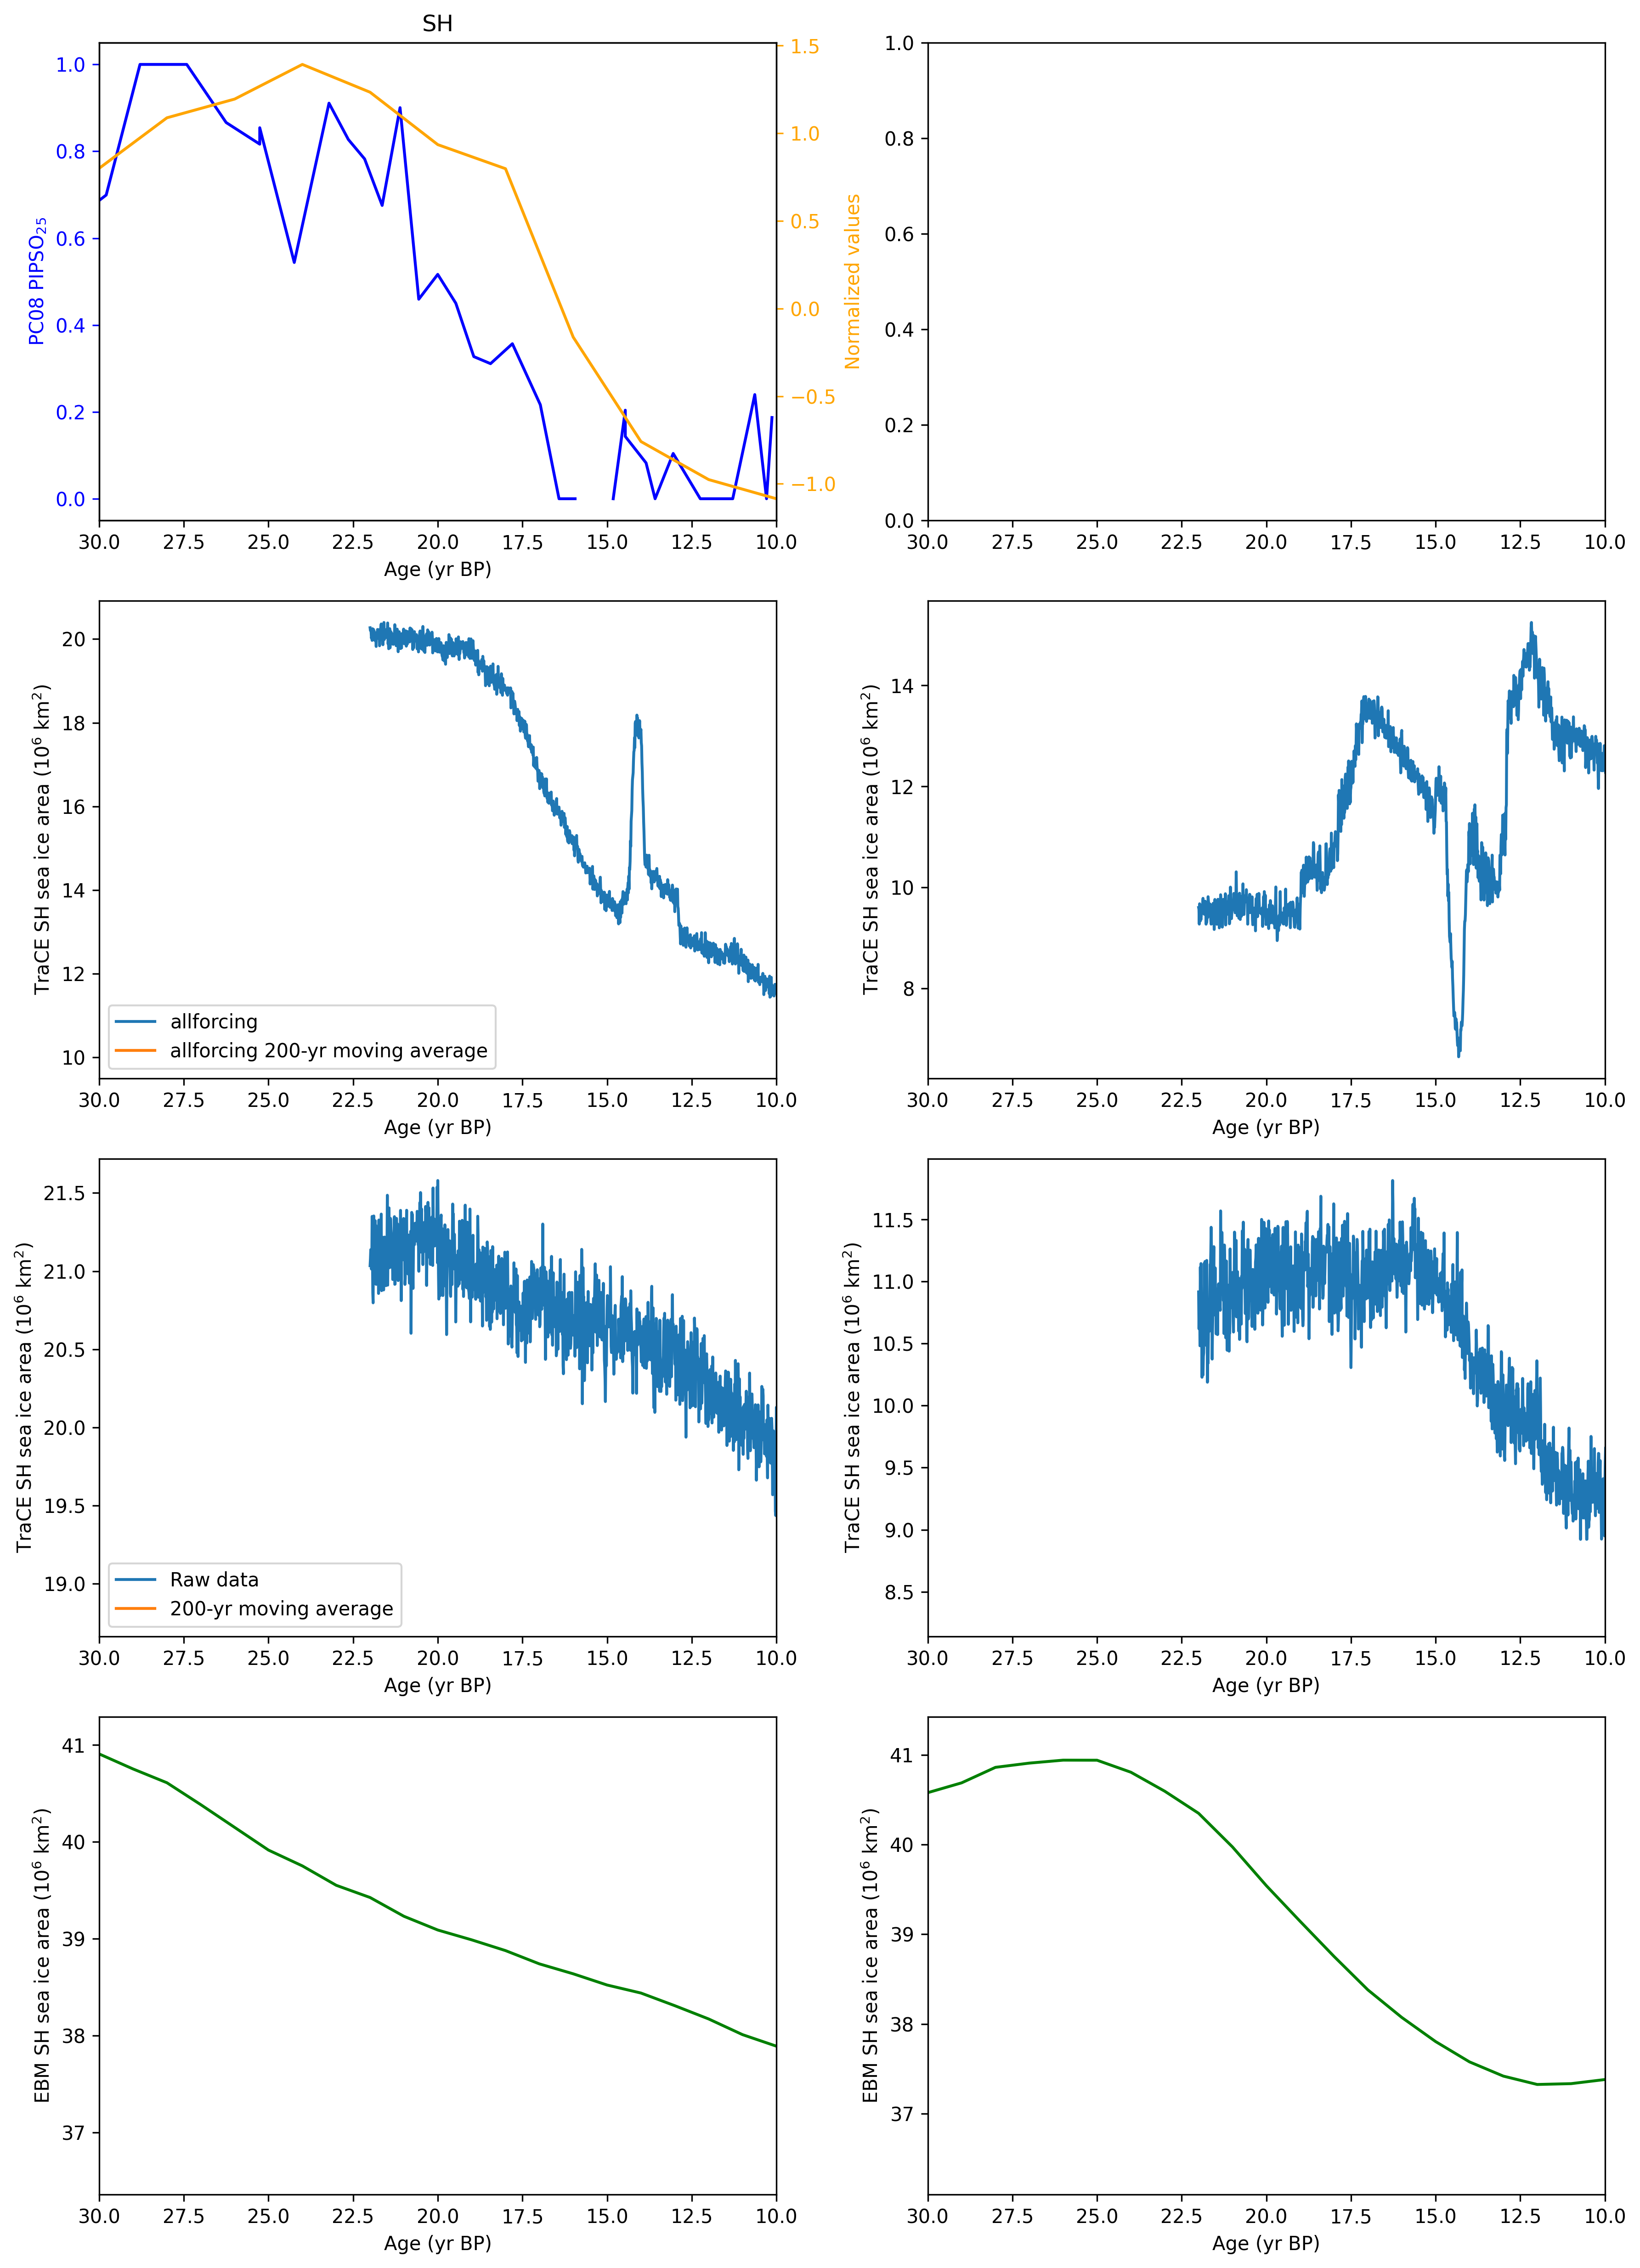

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Define a moving average function
def moving_average(data, points=10):
    return np.convolve(data, np.ones(points)/points, mode='valid')

# Create a 4 by 2 subplot layout to accommodate the two new rows of empty subplots
fig, axs = plt.subplots(4, 2, figsize=(12, 18), dpi=300) # Adjusted figsize to accommodate the new layout
# fig.suptitle('Sea ice area comparison')

smoothing_len = 20

# Assuming asice_trace_orb_sh, asice_trace_orb_nh, results_sh_df, and results_nh_df are defined elsewhere in your code

# Apply the moving average
smoothed_asice_trace_orb_sh = moving_average(asice_trace_orb_sh[:, 1], smoothing_len)
smoothed_asice_trace_orb_nh = moving_average(asice_trace_orb_nh[:, 1], smoothing_len)
smoothed_asice_trace_allforcing_sh = moving_average(asice_trace_allforcing_sh[:, 1], smoothing_len)
smoothed_asice_trace_allforcing_nh = moving_average(asice_trace_allforcing_nh[:, 1], smoothing_len)

# Adjust x-axis data for moving average
adjusted_x_sh = asice_trace_orb_sh[9:-10, 0]
adjusted_x_nh = asice_trace_orb_nh[9:-10, 0]


# plot the df_proxy_seaice_pc on the second subplot
# axs[0, 0].plot(df_proxy_seaice_pc['age'], df_proxy_seaice_pc['pc1'], label='proxy')
# plot the first two columns of the proxy data
axs[0, 0].plot(df_proxy_EASIC['age'], df_proxy_EASIC['pipso25c0.45'], color='b',label='proxy')
axs[0, 0].set_title('SH')
axs[0, 0].set_xlabel('Age (yr BP)')
axs[0, 0].set_ylabel('PC08 PIPSO$_2$$_5$')
axs[0, 0].invert_xaxis()
# set the color of ylabels and ytick labels to match the line color
axs[0, 0].yaxis.label.set_color('blue')
axs[0, 0].tick_params(axis='y', colors='blue')

ax2 = axs[0, 0].twinx()
ax2.plot(df_proxy_seaice_pc['age'], df_proxy_seaice_pc['pc1'], label='proxy', color='orange')
ax2.set_ylabel('Normalized values')
ax2.invert_xaxis()
ax2.yaxis.label.set_color('orange')
ax2.tick_params(axis='y', colors='orange')





# axs[1,0].plot(asice_trace_orb_sh[:, 0], asice_trace_orb_sh[:, 1], label='raw data')
# axs[1,0].plot(adjusted_x_sh, smoothed_asice_trace_orb_sh,label='200-yr moving average')
axs[1,0].plot(asice_trace_allforcing_sh[:, 0]/1000, asice_trace_allforcing_sh[:, 1], label='allforcing')
axs[1,0].plot(adjusted_x_sh, smoothed_asice_trace_allforcing_sh,label='allforcing 200-yr moving average')
# axs[1,0].set_title('SH')
axs[1,0].set_xlabel('Age (yr BP)')
axs[1,0].set_ylabel('TraCE SH sea ice area ($10^6$ km$^2$)')
axs[1,0].legend()
axs[1,0].invert_xaxis()



# axs[1,1].plot(asice_trace_orb_nh[:, 0], asice_trace_orb_nh[:, 1], label='NH')
# axs[1,1].plot(adjusted_x_nh, smoothed_asice_trace_orb_nh)
axs[1,1].plot(asice_trace_allforcing_nh[:, 0]/1000, asice_trace_allforcing_nh[:, 1], label='allforcing')
axs[1,1].plot(adjusted_x_nh, smoothed_asice_trace_allforcing_nh,label='allforcing 200-yr moving average')
# axs[1,1].set_title('NH')
axs[1,1].set_xlabel('Age (yr BP)')
axs[1,1].set_ylabel('TraCE SH sea ice area ($10^6$ km$^2$)')
axs[1,1].invert_xaxis()

# You must update the indexes for the existing plots from axs[0, X] and axs[1, X] to axs[2, X] and axs[3, X]
# Plotting TraCE data
axs[2, 0].plot(asice_trace_orb_sh[:, 0]/1000, asice_trace_orb_sh[:, 1], label='Raw data')
axs[2, 0].plot(adjusted_x_sh, smoothed_asice_trace_orb_sh, label='200-yr moving average')
# axs[2, 0].set_title('TraCE orbital forcing, SH')
axs[2, 0].set_xlabel('Age (yr BP)')
axs[2, 0].set_ylabel('TraCE SH sea ice area ($10^6$ km$^2$)')
axs[2, 0].invert_xaxis()
axs[2, 0].legend(loc='lower left')

axs[2, 1].plot(asice_trace_orb_nh[:, 0]/1000, asice_trace_orb_nh[:, 1], label='TraCE, raw data')
axs[2, 1].plot(adjusted_x_nh, smoothed_asice_trace_orb_nh, label='TraCE, smoothed')
# axs[2, 1].set_title('TraCE orbital forcing, NH')
axs[2, 1].set_xlabel('Age (yr BP)')
axs[2, 1].set_ylabel('TraCE SH sea ice area ($10^6$ km$^2$)')
axs[2, 1].invert_xaxis()

# Plotting EBM data
axs[3, 0].plot(results_sh_df['age'], results_sh_df['iceA'], label='EBM SH', color='green')
# axs[3, 0].set_title('EBM orbital forcing, SH')
axs[3, 0].set_xlabel('Age (yr BP)')
axs[3, 0].set_ylabel('EBM SH sea ice area ($10^6$ km$^2$)')
axs[3, 0].invert_xaxis()

axs[3, 1].plot(results_nh_df['age'], results_nh_df['iceA'], label='EBM NH', color='green')
# axs[3, 1].set_title('EBM orbital forcing, NH')
axs[3, 1].set_xlabel('Age (yr BP)')
axs[3, 1].set_ylabel('EBM SH sea ice area ($10^6$ km$^2$)')
axs[3, 1].invert_xaxis()

# # Adjusting layout and adding legends
for ax in axs.flat:
    # Adjust x lim
    ax.set_xlim(30, 10)

# # Optionally, make the first two rows of subplots invisible as they are placeholders
# for ax in axs[:2, :].flat:
#     ax.set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


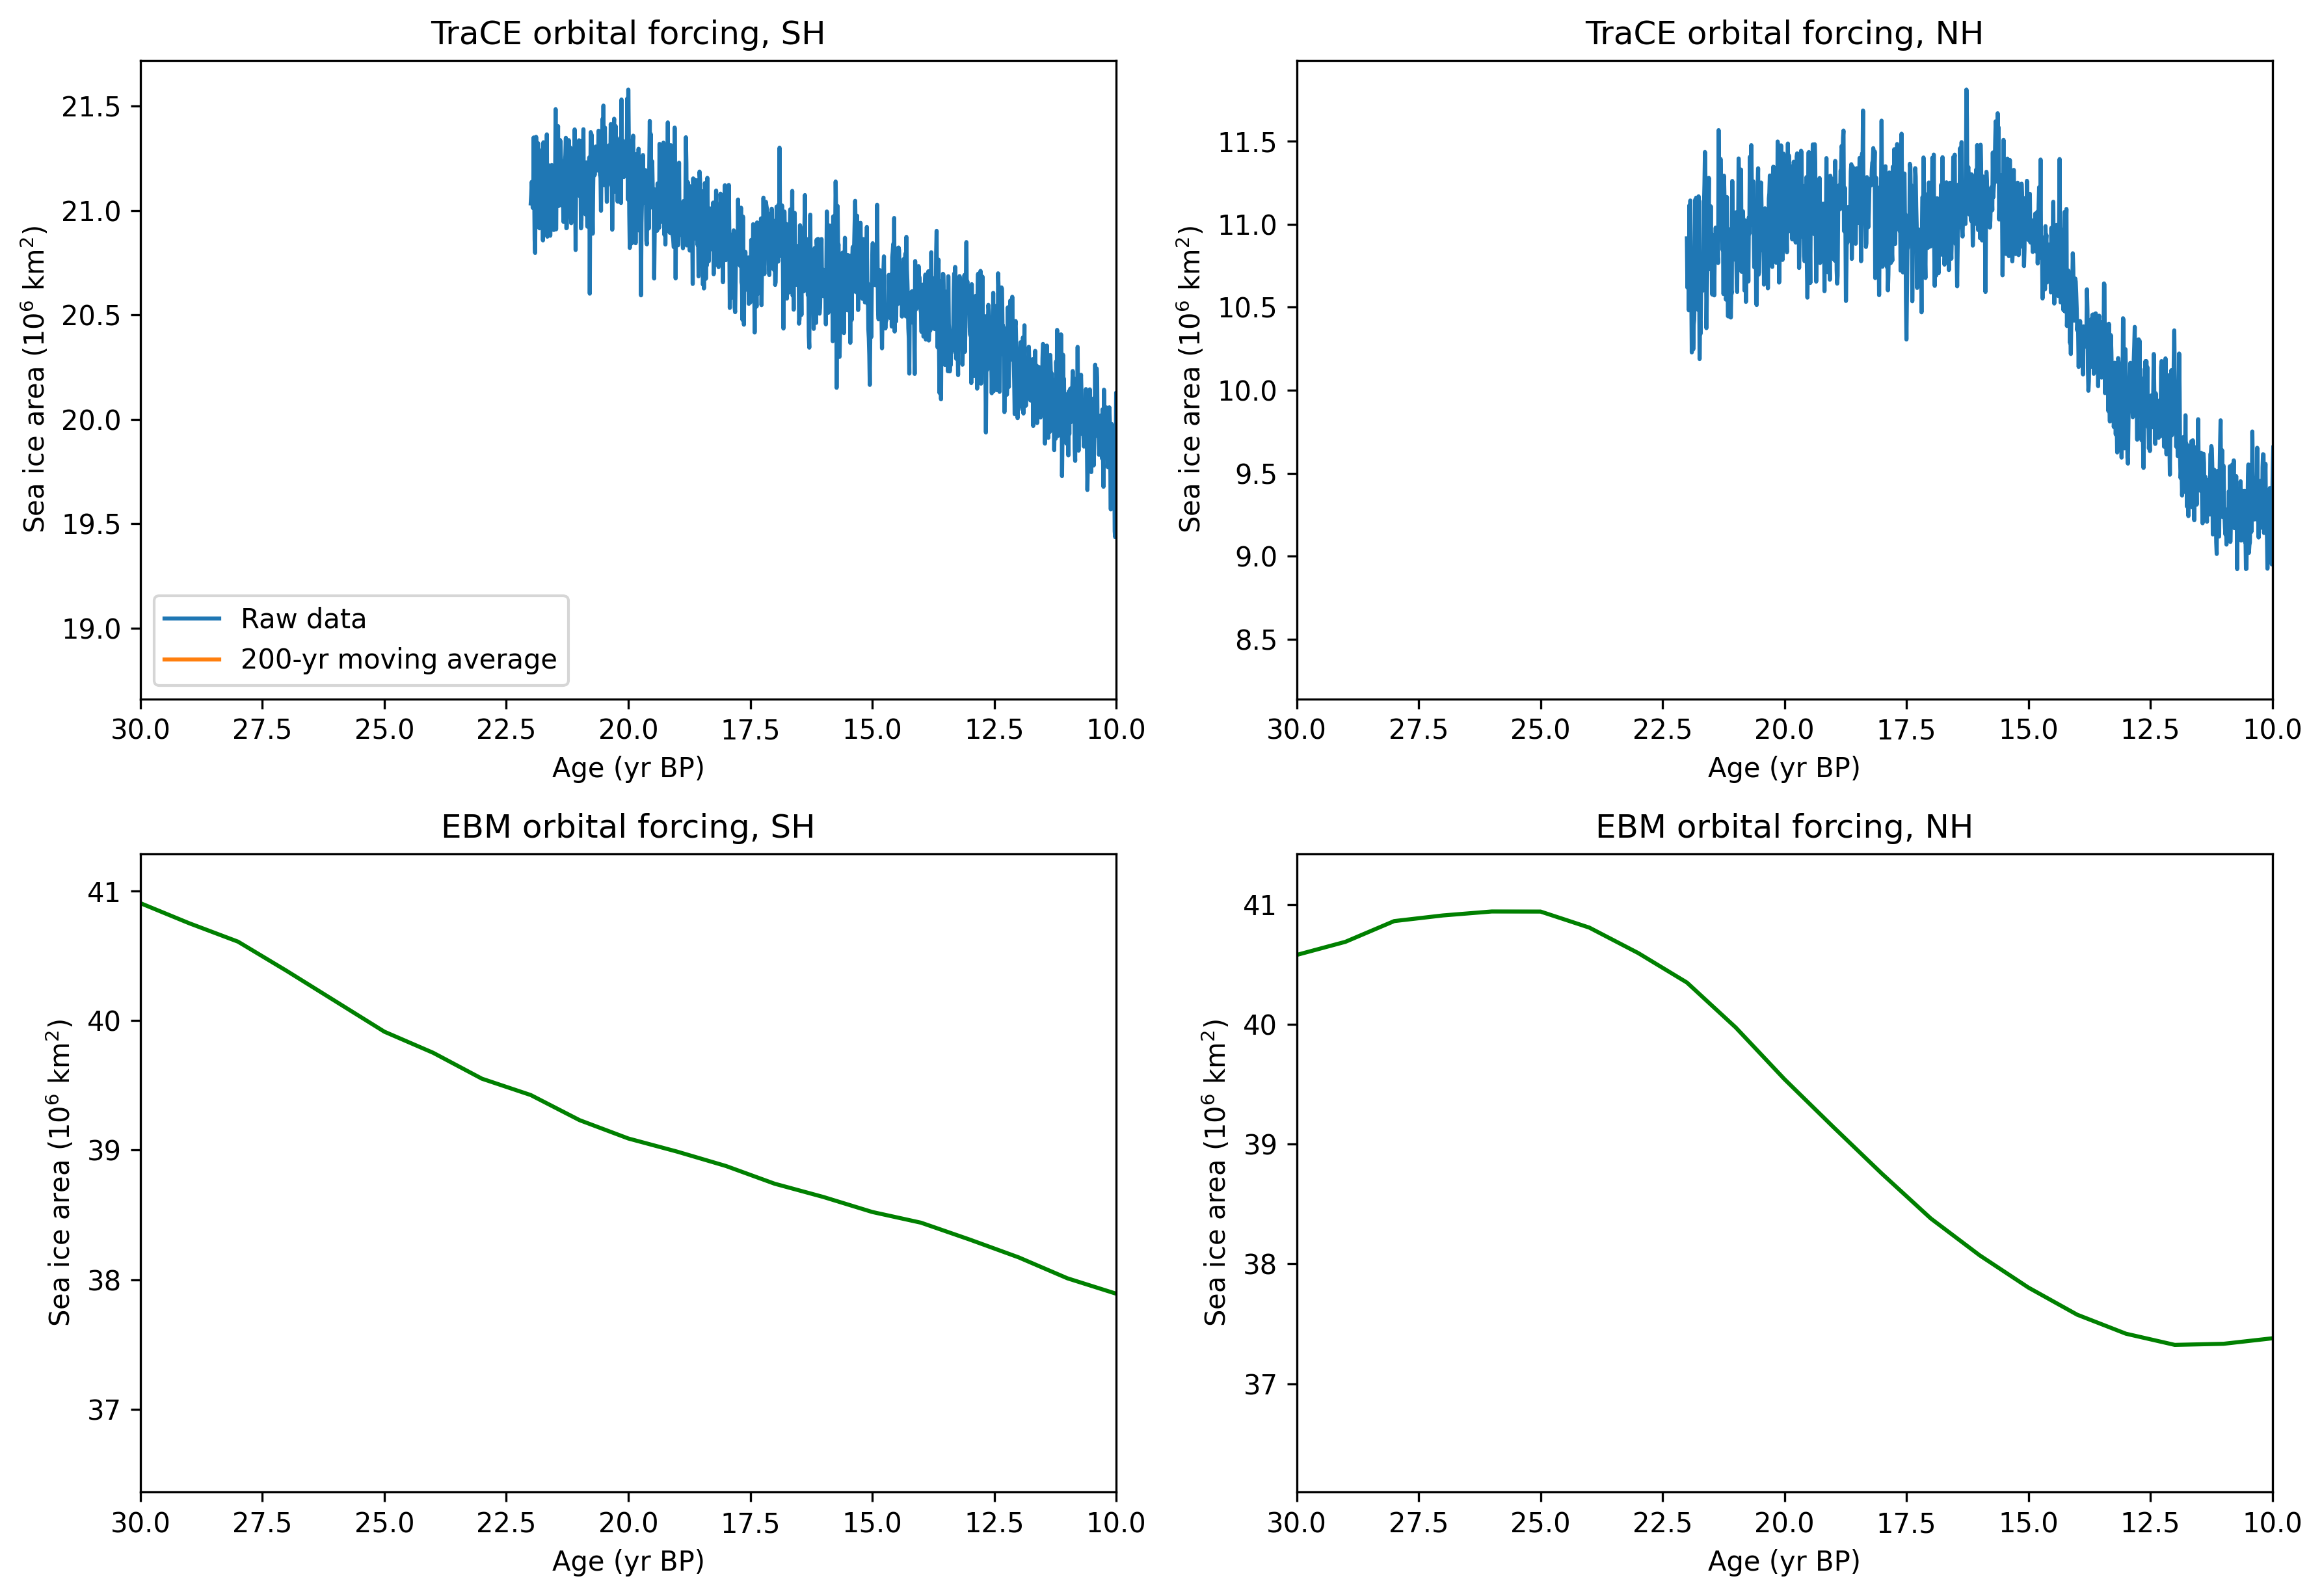

In [12]:
import matplotlib.pyplot as plt
import numpy as np


# Define a moving average function
def moving_average(data, points=10):
    return np.convolve(data, np.ones(points)/points, mode='valid')

# Create a 2 by 2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(12, 9), dpi=300)
# fig.suptitle('Sea ice area comparison')

smoothing_len = 20

# Apply the moving average
smoothed_asice_trace_orb_sh = moving_average(asice_trace_orb_sh[:, 1], smoothing_len)
smoothed_asice_trace_orb_nh = moving_average(asice_trace_orb_nh[:, 1], smoothing_len)

# Adjust x-axis data for moving average
adjusted_x_sh = asice_trace_orb_sh[9:-10, 0]
adjusted_x_nh = asice_trace_orb_nh[9:-10, 0]


# Plotting TraCE data

axs[0, 0].plot(asice_trace_orb_sh[:, 0]/1000, asice_trace_orb_sh[:, 1], label='Raw data')
axs[0, 0].plot(adjusted_x_sh, smoothed_asice_trace_orb_sh, label='200-yr moving average')
axs[0, 0].set_title('TraCE orbital forcing, SH')
axs[0, 0].set_xlabel('Age (yr BP)')
axs[0, 0].set_ylabel('Sea ice area ($10^6$ km$^2$)')
axs[0, 0].invert_xaxis()
# legend in lower left
axs[0, 0].legend(loc='lower left')

axs[0, 1].plot(asice_trace_orb_nh[:, 0]/1000, asice_trace_orb_nh[:, 1], label='TraCE, raw data')
axs[0, 1].plot(adjusted_x_nh, smoothed_asice_trace_orb_nh, label='TraCE, smoothed')
axs[0, 1].set_title('TraCE orbital forcing, NH')
axs[0, 1].set_xlabel('Age (yr BP)')
axs[0, 1].set_ylabel('Sea ice area ($10^6$ km$^2$)')
axs[0, 1].invert_xaxis()

# Plotting EBM data
axs[1, 0].plot(results_sh_df['age'], results_sh_df['iceA'], label='EBM SH', color='green')
axs[1, 0].set_title('EBM orbital forcing, SH')
axs[1, 0].set_xlabel('Age (yr BP)')
axs[1, 0].set_ylabel('Sea ice area ($10^6$ km$^2$)')
axs[1, 0].invert_xaxis()
# legend
# axs[1, 0].legend()

axs[1, 1].plot(results_nh_df['age'], results_nh_df['iceA'], label='EBM NH', color='green')
axs[1, 1].set_title('EBM orbital forcing, NH')
axs[1, 1].set_xlabel('Age (yr BP)')
axs[1, 1].set_ylabel('Sea ice area ($10^6$ km$^2$)')
axs[1, 1].invert_xaxis()

# # Adjusting layout and adding legends
for ax in axs.flat:
    # ax.legend()
    # set x lim
    ax.set_xlim(30, 10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


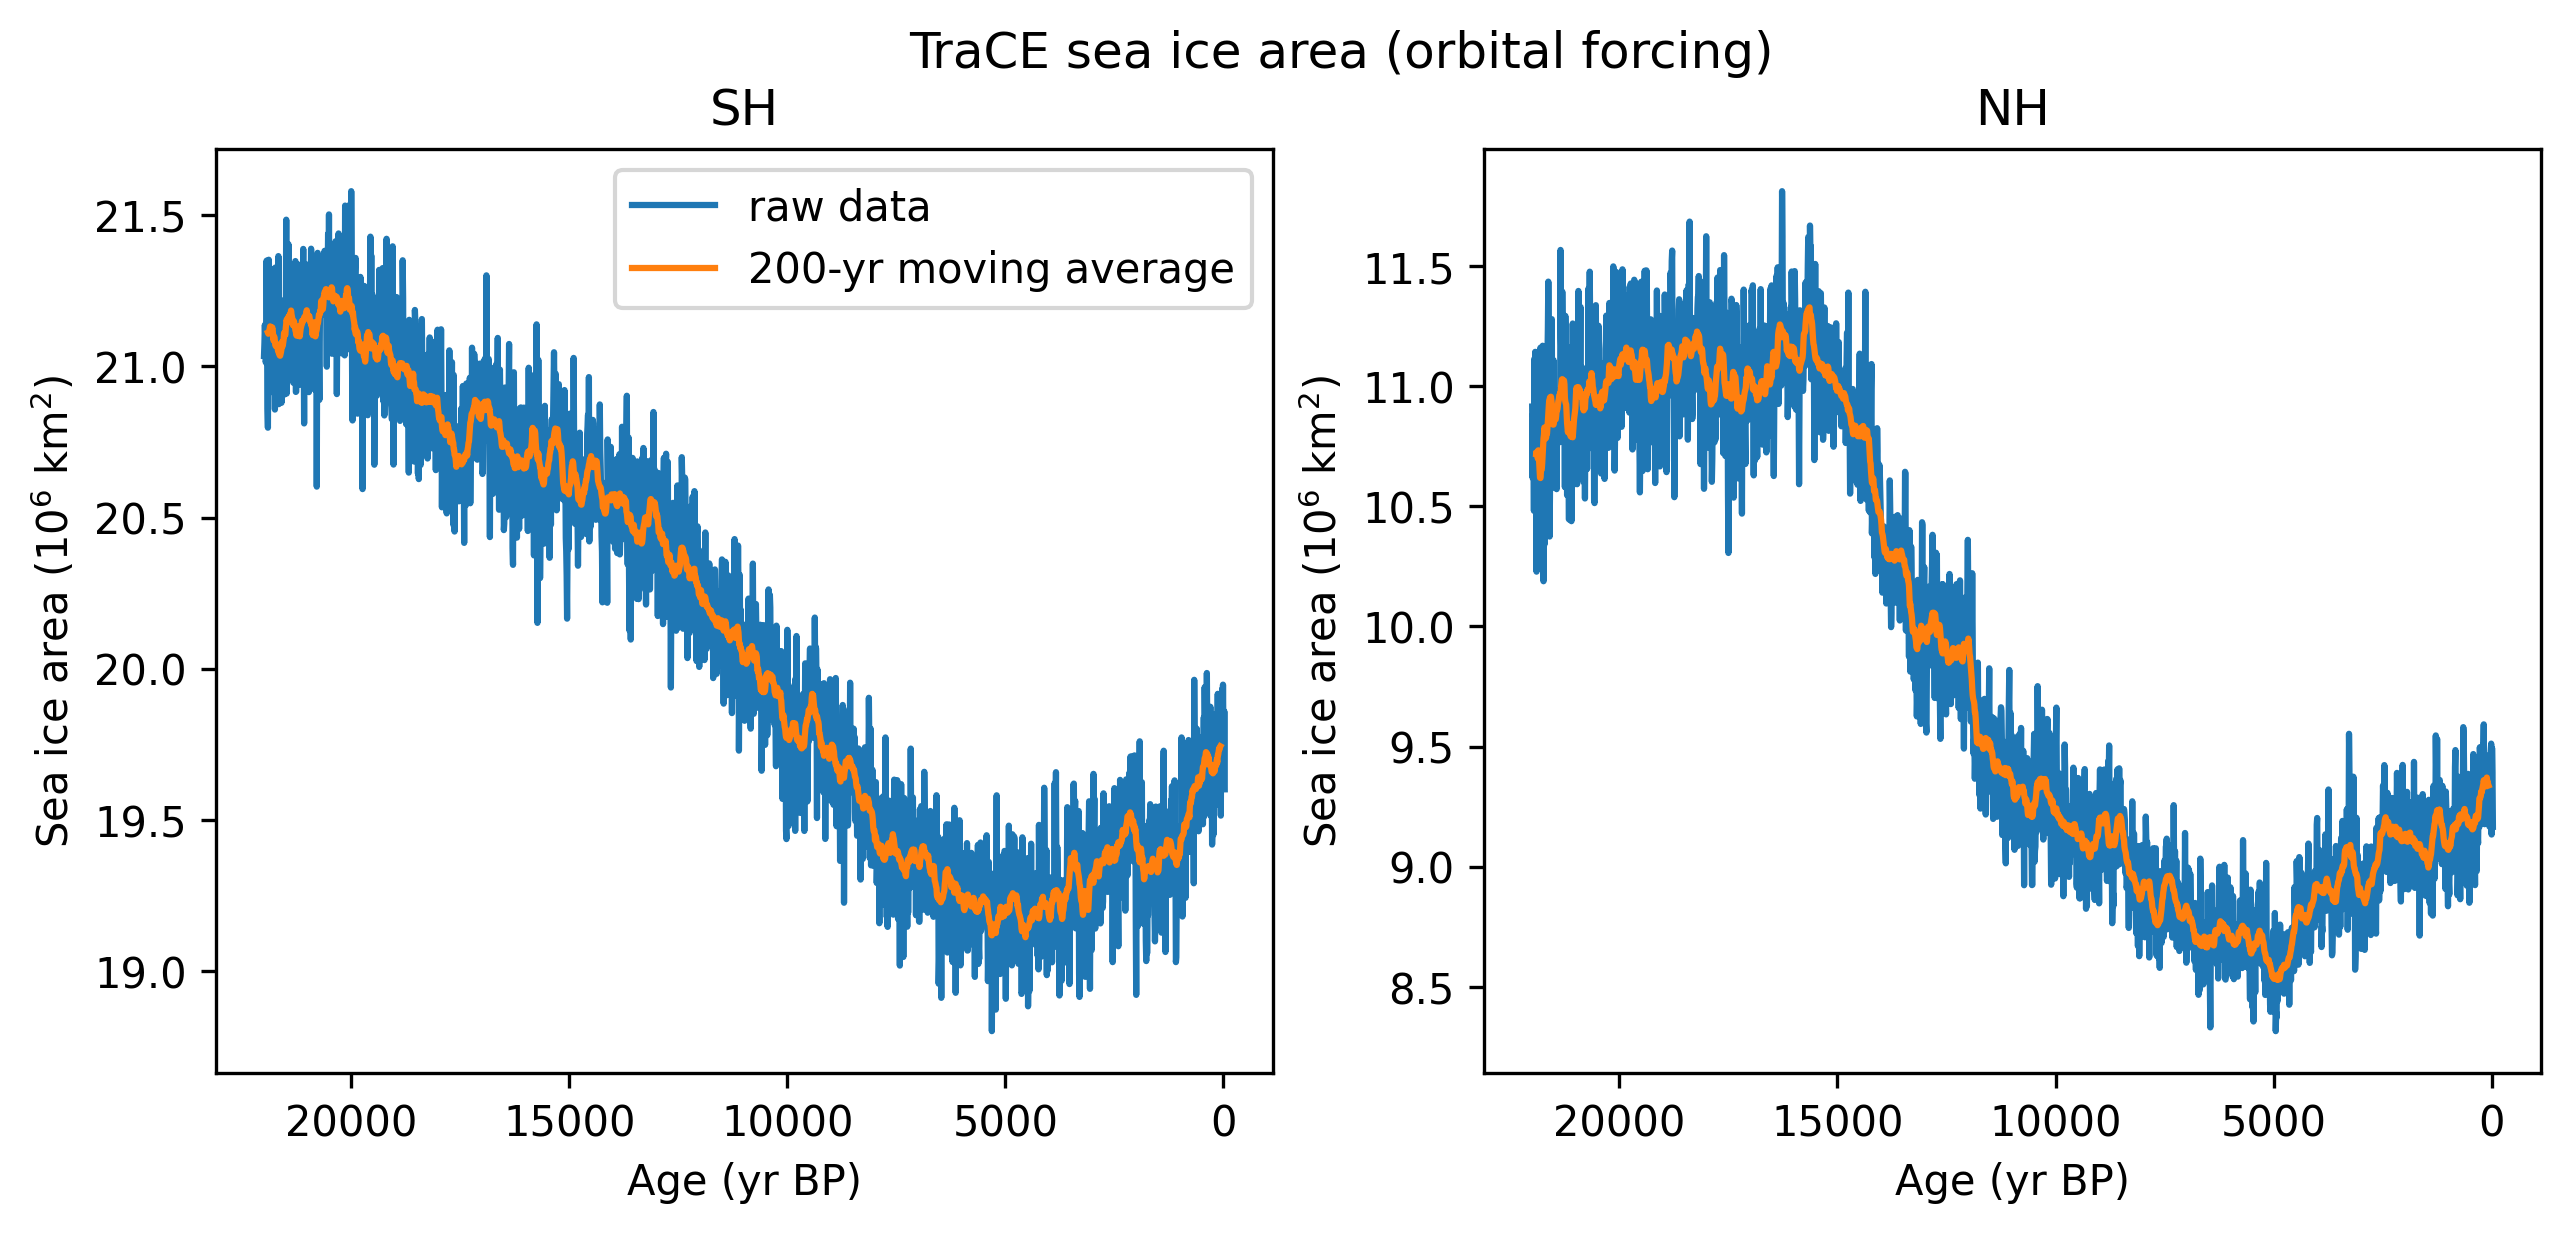

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Smooth the data with a 10-point moving average
def moving_average(data, points=10):
    return np.convolve(data, np.ones(points)/points, mode='valid')

# plot asice_trace_orb_sh and asice_trace_orb_nh side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4),dpi=300)
fig.suptitle('TraCE sea ice area (orbital forcing)')

smoothing_len=20

# Apply the moving average to your data
smoothed_asice_trace_orb_sh = moving_average(asice_trace_orb_sh[:, 1], smoothing_len)
smoothed_asice_trace_orb_nh = moving_average(asice_trace_orb_nh[:, 1], smoothing_len)
smoothed_asice_trace_allforcing_sh = moving_average(asice_trace_allforcing_sh[:, 1], smoothing_len)
smoothed_asice_trace_allforcing_nh = moving_average(asice_trace_allforcing_nh[:, 1], smoothing_len)

# Since the moving average reduces the length of the data, adjust the x-axis data accordingly
adjusted_x_sh = asice_trace_orb_sh[9:-10, 0]  # Adjusting for a 10-point average
adjusted_x_nh = asice_trace_orb_nh[9:-10, 0]  # Same here


ax1.plot(asice_trace_orb_sh[:, 0], asice_trace_orb_sh[:, 1], label='raw data')
ax1.plot(adjusted_x_sh, smoothed_asice_trace_orb_sh,label='200-yr moving average')
# ax1.plot(asice_trace_allforcing_sh[:, 0], asice_trace_allforcing_sh[:, 1], label='allforcing')
# ax1.plot(adjusted_x_sh, smoothed_asice_trace_allforcing_sh,label='allforcing 200-yr moving average')
ax1.set_title('SH')
ax1.set_xlabel('Age (yr BP)')
ax1.set_ylabel('Sea ice area ($10^6$ km$^2$)')
ax1.legend()
ax1.invert_xaxis()

ax2.plot(asice_trace_orb_nh[:, 0], asice_trace_orb_nh[:, 1], label='NH')
ax2.plot(adjusted_x_nh, smoothed_asice_trace_orb_nh)
# ax2.plot(asice_trace_allforcing_nh[:, 0], asice_trace_allforcing_nh[:, 1], label='allforcing')
# ax2.plot(adjusted_x_nh, smoothed_asice_trace_allforcing_nh,label='allforcing 200-yr moving average')
ax2.set_title('NH')
ax2.set_xlabel('Age (yr BP)')
ax2.set_ylabel('Sea ice area ($10^6$ km$^2$)')
ax2.invert_xaxis()

plt.show()
